## Imports

In [32]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Datensätze
**Es kann zwischen folgenden Datensätzen gewählt werden:**

## 1. Animal Faces Dataset von Husaa Anwar
Dieser Datensatz enthält Bilder von Katzen, Hunden und Wildtieren. Er ist aufgeteilt in Trainings- und Validierungsdaten.

## 2. Animal Dataset von Anton Benedetti
Auch dieses Datenet ist in Trainings- und Validierungsdaten unterteilt, behinhaltet diesmal aber Hunde, Katzen, Elefanten, Pferden und Löwen.

---


## Daten Import and Vorbereitung

Im folgenden Code werden die Datensätze heruntergeladen und importiert. Bevor diese für unser CNN bereit sind müssen wir allerdings noch ein paar Anpassungen vornehmen.

1. Laden der Bilder aus Ordnerstruktur.
  - Jeder Unterornder wird als eigene Klasse interpretiert

2. Die Bilder werden auf 128 x 128 Pixel herunterskaliert.

3. Konvertierung von **PIL.image** zu **torch.tensor**
  -PIL.image sind Bildobjekte aus der Python Libary und stellen Bilder in ein für Menschen lesbares Format dar. Das ist für uns allerdings unbrauchbar, da unser Netz nur mit numerischen Werten arbeiten kann. Deswegen wandeln wir diese in **torch.Tensor** um. Das ist ein Pytorch Datentyp, der auf GPU-basiertes Training optimiert ist.

4. Normalisieren der RGB-Kanäle mit Mittelwert 0.5 und Standardabweichung 0.5

4. Datenloader erstellt
  - 32 Bilder pro Batch
  - mit zufälliger Mischung






In [ ]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("andrewmvd/animal-faces")
path2 = kagglehub.dataset_download("antobenedetti/animals")

#print("Path to dataset files:", path)
print("Path to dataset files:", path2)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

#train_dataset = datasets.ImageFolder(os.path.join(path, 'afhq/train'), transform=transform)
#val_dataset = datasets.ImageFolder(os.path.join(path, 'afhq/val'), transform=transform)

train_dataset = datasets.ImageFolder(os.path.join(path2, 'animals/train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(path2, 'animals/val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

classes = train_dataset.classes
print(f"Classes: {classes}")

Path to dataset 2 files: /Users/julian.greiner/.cache/kagglehub/datasets/antobenedetti/animals/versions/5
Classes: ['cat', 'dog', 'elephant', 'horse', 'lion']


## Modellarchitektur: Convolutional Neural Network (**CNN**)

### Aufbau des Netzwerks:
Für die Klassifizeirung von Tierarten wurd ein Convolutional Neural Network gewählt. Diese sind besonders gut für Bildverarbeitung geeignet, da sie in der Lage sind Bildstrukturen effizient zu erfassen und Merkmalsabstraktion über Faltungsprozesse ermöglicht. Diese Faltungsprozesse sind mathematische Operationen bei denen ein kleinerer Filter über das Eingabebild geschoben werden und dann an jeder Position eine gewichtete Summe der überlappenden Pixel zu berechnen. Das Ergebnis daraus ist dann ein Merkmalbild, das bestimmte Muster sichtbar macht.
Anfangs sind die Filter zufällig initialisiert, passen sich aber währen dem Training über "Backpropagation" an.

---

Unsere Klasse AnimalCNN erbt von torch.nn.Module und besteht aus zwei Hauptkomponenten:

#### 1. Convolutional Layers (Merkmalextraktion)

Hier werden zunehmend komplexere Bildmerkmale extrahiert, z.B. Kanten, Formen oder Objektteil.

Faltung:
- Kernalgröße 3x3
-Padding 1

Aktivierungsfunktion:
- ReLU (Rectified LinearUnit) unterstützt nicht-lineare Entscheidungsgrenzen

Pooling:
- 2x2 <- zur reduktion räumlicher Dimensionen bei gleichzeitiger Erhaltung wesentlicher Merkmale


#### 2. Fully Connected Layers (Klassifikation)

Bilden den letzen Teil des CNN und übernehmen die Klassifikation auf Basis der extrahierten Merkmale. Jeder Neuron dieser Schicht ist mit allen Neuronen der vorherigen Schicht verbunden, wodurch eine gewichtete Kombination aller Merkmalsinformationen entsteht. Damit kann das Netzt entscheiden zu welcher Klasse ein Bild gehört.

Flatten:
- um in einen Vektor zu überführen

Linear(...):
- verbundene Schichten klassifizieren das extrahierte Merkmalsmuster.



#### Vorwärtsdurchläufe
Wendet Convolutional und Fully Connected Layers an






In [34]:
class AnimalCNN(nn.Module):
    def __init__(self, num_classes):
        super(AnimalCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Training

Zuerst wird hier überprüft, welche Geräte zum Training zur Verfügung stehen und überprüft, ob sie CUDA fähig sind. CUDA fähige GPUs sind optimal, da diese sehr gut viele prozesse parrallel berechnen könne as perfekt für das Training eines Neuronalen Netz ist.

Wurde ein passendes Gerät gefunden, so wird jetzt das Modell auf dieses verschoben.

#### Verlustfunktion
Es wird eine Verlustfunktion hinzugefügt, die die Differenz zwischen vorhergesagter Klassenverteilung und tatsächlichen Label errechnet.

#### Optimierer
Außerdem wird ein Optimierer hinzugefügt, der mit dem Gradientenabstieg arbeitet und eine Lernrate übergeben bekommt. Dieser wird benötigt, um das Netz je nach Verlust dem entsprechend anzupassen.


In [35]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device2)
model = AnimalCNN(num_classes=len(classes)).to(device)

print("device:", device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device: cpu


## Trainingsscheife

Der Trainingsprozess läuft über mehrere Epochen mit Batches trainiert, wobei jede Epoche einmal durch den gesamten Trainingsdatensatz iteriert, wodurch die Generalisierungsfähigkeit des Modells. Durch Backpropagation und dem Optimierer verbessert das Netzt seine parameter. Der Verlust wird pro Epoche dokumentiert um den Lernfortschritt einsehen zu können (mit live Anzeige).



In [36]:
epochs = 1
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


Epoch 1/1: 100%|██████████| 422/422 [04:26<00:00,  1.58it/s, loss=0.468]

Epoch 1 Average Loss: 0.8965


### Training Loss

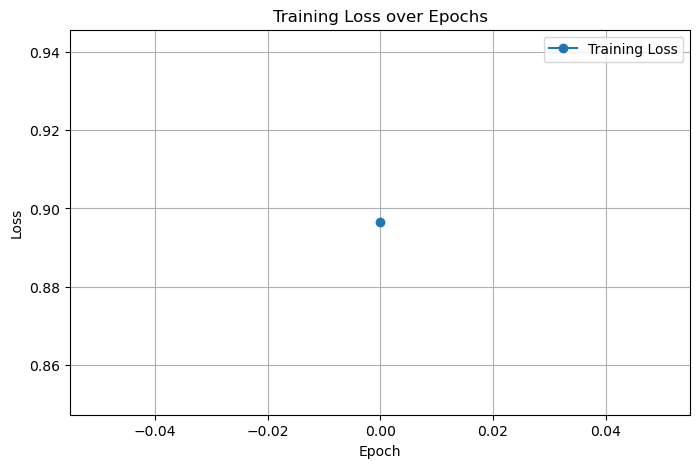

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o', label='Training Loss')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## 1 Visualisierung des Trainingsverlusts

Der folgende Code erstellt ein Diagramm, das den Verlauf des Trainingsverlusts (`Loss`) über alle Epochen hinweg zeigt. Jeder Punkt steht dabei für den durchschnittlichen Verlust pro Epoche.
```python
# Neues Plot-Fenster mit einer definierten Größe
plt.figure(figsize=(8, 5))

# Wir plotten die gespeicherten Trainingsverluste.
# Die Marker "o" heben die einzelnen Punkte in der Linie hervor.
plt.plot(train_losses, marker='o', label='Training Loss')

# Titel für das Diagramm
plt.title("Training Loss over Epochs")

# Beschriftung der X- und Y-Achsen
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Anzeige der Legende (in diesem Fall: "Training Loss")
plt.legend()

# Ein Gitter erleichtert das Ablesen des Plots
plt.grid(True)

# Zeige das Diagramm an
plt.show()
```
# Erklärung des Diagrammverlaufs

Das gezeigte Diagramm stellt den Trainingsverlust dar, der während des Trainings berechnet wird.

Zu Beginn des Trainings ist der Loss-Wert in der Regel sehr hoch, da das Modell noch keine sinnvollen Vorhersagen treffen kann.  
In den ersten Epochen sinkt der Verlust schnell, weil das Modell grundlegende Muster wie Kanten oder Farben in den Bildern lernt.  
In höheren Epochen verlangsamt sich der Abfall des Loss-Werts immer mehr, da das Netz die grundlegenden Muster bereits erlernt hat und nur durch höhere Komplexität weitere Verbesserungen erreicht werden können.

Gegen Ende erreicht der Loss einen stabilen Wert, was auf eine Konvergenz des Trainings hinweist.  
Diese typische Kurve (starker Abfall am Anfang, langsamer Abfall später, Plateau am Ende) ist ein Zeichen dafür, dass das Modell effektiv lernt und sich an die Trainingsdaten anpasst.

### Evaluation

In [38]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 78.16%


# Erklärung der Evaluierung

Bei der Modell-Evaluierung wird die Leistung des trainierten Modells auf neuen, ungesehenen Daten überprüft.  
Dazu wird der sogenannte Validierungsdatensatz genutzt, der während des Trainings nicht betrachtet wurde. Dies stellt sicher, dass das Modell nicht nur auf die Trainingsdaten passt, sondern auch auf andere Bilder gut funktioniert.

Zunächst wird das Modell in den Evaluierungsmodus versetzt. In diesem Modus sind Schichten wie Dropout deaktiviert und Batch-Normalisierung verwendet gespeicherte Mittelwerte und Varianzen, statt sie neu aus den aktuellen Eingaben zu berechnen. Dadurch wird ein konsistentes Verhalten des Modells während der Auswertung sichergestellt.

Im nächsten Schritt wird die Berechnung von Gradienten ausgeschaltet. Das spart Speicher und beschleunigt die Ausführung, da beim Testen keine Gewichtsaktualisierungen notwendig sind.

Für jedes Bildpaar im Validierungsdatensatz werden dann folgende Schritte durchgeführt:  
- Die Eingabebilder und die zugehörigen Labels werden auf das passende Gerät geladen (CPU, GPU oder MPS).  
- Das Modell berechnet Vorhersagen (Wahrscheinlichkeiten für alle Klassen).  
- Die Klasse mit der höchsten Wahrscheinlichkeit wird als Vorhersage gewählt.  
- Diese Vorhersage wird mit dem tatsächlichen Label verglichen. Wenn die Vorhersage korrekt ist, wird ein Zähler für richtige Ergebnisse erhöht.

Am Ende der Schleife wird die Gesamtzahl der korrekten Vorhersagen durch die Gesamtzahl der Bilder geteilt und mit 100 multipliziert. Das Ergebnis ist die Genauigkeit in Prozent.  

Diese Genauigkeit ist eine wichtige Kennzahl:  
 - Sie zeigt, wie gut das Modell verallgemeinert und nicht nur die Trainingsdaten „auswendig gelernt“ hat.  
 - Eine hohe Genauigkeit deutet darauf hin, dass das Modell die zugrunde liegenden Muster der Bilder erkannt hat und erfolgreich neue Bilder klassifizieren kann.

## Klassifizierung eines Bildes

In [39]:
from PIL import Image
import torchvision.transforms as transforms

def classify_image(image, model, class_names, device):
    # Transform must match training preprocessing
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Load and preprocess image

    image = transform(image).unsqueeze(0).to(device)  # add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]

# Erklärung der Einzelbildklassifikation (Inference)

Nachdem das Modell trainiert und evaluiert wurde, kann es verwendet werden, um neue, einzelne Bilder zu klassifizieren.  
Dafür wird eine spezielle Funktion definiert, die ein Bild als Eingabe nimmt und eine Vorhersage zurückgibt.

Zuerst muss das Eingabebild vorverarbeitet werden, um es in das Format zu bringen, das das Modell erwartet:  
- Die Bildgröße wird auf die während des Trainings genutzte Größe (z.B. 128x128 Pixel) skaliert.  
- Das Bild wird in einen Tensor umgewandelt, das heißt, es wird in eine numerische Matrix konvertiert, die vom Modell verarbeitet werden kann.  
- Die Pixelwerte werden normalisiert, sodass sie in einem bestimmten Wertebereich liegen (z.B. zwischen -1 und 1). Diese Normalisierung entspricht genau der, die auch während des Trainings angewandt wurde, um Konsistenz sicherzustellen.

Anschließend wird dem Tensor eine zusätzliche Dimension hinzugefügt, um die Batch-Größe darzustellen – auch wenn nur ein einzelnes Bild klassifiziert wird, erwartet das Modell eine Batch-Struktur.

Das Modell wird in den Evaluierungsmodus versetzt, damit keine Trainings-spezifischen Operationen (wie Dropout) aktiv sind. Innerhalb eines Kontextes, der die Berechnung von Gradienten deaktiviert (für Effizienz und Speicherersparnis), wird das Bild durch das Modell geführt und eine Vorhersage erzeugt.

Die Vorhersage besteht aus Wahrscheinlichkeiten für jede mögliche Klasse. Die Klasse mit der höchsten Wahrscheinlichkeit wird als Ergebnis der Klassifikation ausgewählt.

Abschließend gibt die Funktion den Namen der vorhergesagten Klasse zurück, sodass der Benutzer direkt erkennen kann, zu welcher Tierklasse das Bild gehört.

Diese Vorgehensweise ermöglicht es, das trainierte Modell praktisch einzusetzen, um einzelne Bilder schnell und zuverlässig zu klassifizieren.


In [40]:
image_path = os.path.join(path2, 'animals/val/dog/dog117.jpg')
image = Image.open(image_path).convert("RGB")
result = classify_image(image, model, classes, device)
print("Predicted class:", result)


Predicted class: dog


# Erklärung der Beispielanwendung zur Bildklassifikation

Um die zuvor definierte Klassifikationsfunktion zu testen, wird ein konkretes Beispielbild verwendet.  

Zunächst wird der Pfad zu einem Bild festgelegt, das klassifiziert werden soll. In diesem Fall handelt es sich um ein Bild aus dem Validierungsdatensatz, das einen Hund zeigt.

Das Bild wird mit der Bibliothek PIL (Python Imaging Library) geöffnet und in den RGB-Farbmodus konvertiert. Dies stellt sicher, dass das Bild drei Farbkanäle besitzt, wie es das Modell erwartet.

Anschließend wird die Klassifikationsfunktion aufgerufen und das geladene Bild zusammen mit dem trainierten Modell, den Klassennamen und dem verwendeten Gerät (CPU, GPU oder MPS) übergeben.

Die Funktion gibt die vorhergesagte Klasse zurück, die dann in der Konsole ausgegeben wird.

Diese Vorgehensweise demonstriert, wie das trainierte Modell praktisch angewendet werden kann, um einzelne Bilder zu klassifizieren. Durch das Ändern des Bildpfads kann diese Methode flexibel auf beliebige Bilder angewendet werden.

Dies ist ein wichtiger Schritt, um die praktische Tauglichkeit des Modells zu überprüfen und es in realen Anwendungen einzusetzen.


# Persönliches Fazit

## Vorgehen
- Projekt entschieden --> Klassifizierung
- Datensätze herausgesucht
- Schrittweise Programm aufgebaut:
    - datensatz importiert/eingebunden
    - Daten vorbereitet
    - KI-Model aufgebaut
    - KI mit Trainingsdaten trainiert
    - Evaluation der KI
- Testing 


## Hindernisse
- Da erstes KI-Projekt neues Umfeld --> viel einlesen und neue unbekannte Umgebungen
- Probleme bei der Nutzung von Tensorflow --> wechsel auf Pytorch
- Zu wenig Leistung durch CPU Verwendung -> lange Laufzeiten
--> Konnten über GoogleColab schließlich die GPU verwenden

## Learnings
- Erste KI-Erfahrung --> Grundlage für zukünftige Projekte
- Einarbeitung in JupyterNotebook

